In [1]:
!pip install opencv-python numpy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
import joblib


In [3]:
class CameraPipeline:
    def __init__(self, canny_low=50, canny_high=150):
        self.canny_low = canny_low
        self.canny_high = canny_high

        # Storage for images and derived maps
        self.images = {}            # frame_id -> grayscale image
        self.edge_maps = {}         # frame_id -> binary edges
        self.dist_transforms = {}   # frame_id -> float32 distance map

   
    # Step 1: Load & preprocess image
    def load_image(self, frame_id: int, path: str):
        # Load an image from disk, convert to grayscale, store by frame_id.
        
        img = cv2.imread(path, cv2.IMREAD_COLOR)
        if img is None:
            raise FileNotFoundError(f"Could not load image: {path}")

        # For now: no undistortion (no K/distortion yet)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        self.images[frame_id] = gray
        return gray

    # Step 2: Edge detection (Canny edges)
    def compute_edges(self, frame_id: int):
        # Compute Canny edges for the stored grayscale image.
        
        if frame_id not in self.images:
            raise KeyError(f"No image for frame_id={frame_id}")

        gray = self.images[frame_id]

        edges = cv2.Canny(gray, self.canny_low, self.canny_high)
        
        # Make edges strictly either 0 or 255
        edges = (edges > 0).astype(np.uint8) * 255

        self.edge_maps[frame_id] = edges
        return edges


    # Step 3: Distance transform from edge map
    def compute_distance_transform(self, frame_id: int):
      # Compute distance transform from the edge map. Pixels on edges have distances close to 0. 
      # Pixels far from edges tend to have large distances.

        if frame_id not in self.edge_maps:
            raise KeyError(f"No edge map for frame_id={frame_id}")

        edges = self.edge_maps[frame_id]

        # distanceTransform calculates distance of every pixel in the image and the corresponding nearest 0 pixel.
        # Currently, we have edges = 255 on edge, 0 elsewhere.
        dist = cv2.distanceTransform(
            255 - edges,  # Since we need distance of every pixel to nearest edge, we invert so edges become 0, background 255
            distanceType=cv2.DIST_L2,
            maskSize=5
        )

        # Normalize (0 <= distance <=1 )
        if dist.max() > 0:
            dist_norm = dist / dist.max()
        else:
            dist_norm = dist

        self.dist_transforms[frame_id] = dist_norm.astype(np.float32)
        return dist_norm

        
    # Step 4: Scoring API used later by the optimizer
    def score_projection(self, frame_id: int, projected_pixels: np.ndarray, sigma: float = 2.0) -> float:
       # Score a set of projected 2D points for alignment with image edges. Higher the score, better the alignment.

        if frame_id not in self.dist_transforms:
            raise KeyError(f"No distance transform for frame_id={frame_id}")

        dist = self.dist_transforms[frame_id]
        h, w = dist.shape

        if len(projected_pixels) == 0:
            return 0.0

        # Round to nearest pixel indices
        pts = projected_pixels.astype(np.int32)

        # Keep only those lidar points that are inside image bounds
        mask = (
            (pts[:, 0] >= 0) & (pts[:, 0] < w) &
            (pts[:, 1] >= 0) & (pts[:, 1] < h)
        )
        pts = pts[mask]
        if pts.shape[0] == 0:
            return 0.0

        # Gather distances from dist map
        d_vals = dist[pts[:, 1], pts[:, 0]]  # note: [row, col] => [v, u]

        # Convert distances to scores (smaller distance -> larger score)
        # score = exp(-d^2 / (2*sigma^2))
        scores = np.exp(-(d_vals ** 2) / (2.0 * sigma ** 2))

        return float(scores.sum())

   
    # Utility: visualize edges & distances
    def debug_show(self, frame_id: int, max_width: int = 1280, max_height: int = 720):
      # Show original image, edges, and distance transform side-by-side. The result is downscaled to fit within (max_width, max_height).
      
        if frame_id not in self.images:
            raise KeyError(f"No image for frame_id={frame_id}")
        if frame_id not in self.edge_maps:
            raise KeyError(f"No edge map for frame_id={frame_id}")
        if frame_id not in self.dist_transforms:
            raise KeyError(f"No dist transform for frame_id={frame_id}")

        img = self.images[frame_id]
        edges = self.edge_maps[frame_id]
        dist = self.dist_transforms[frame_id]

        # Normalize distance for display
        dist_disp = (dist * 255).astype(np.uint8)

        # Make them color for stacking
        img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
        edges_color = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
        dist_color = cv2.applyColorMap(dist_disp, cv2.COLORMAP_JET)

        vis = np.hstack([img_color, edges_color, dist_color])

        # Resize to fit on screen
        h, w = vis.shape[:2]
        scale = min(max_width / w, max_height / h, 1.0)  # only shrink
        if scale < 1.0:
            vis = cv2.resize(vis, (int(w * scale), int(h * scale)), interpolation=cv2.INTER_AREA)

        cv2.namedWindow(f"frame {frame_id}: [image | edges | dist]", cv2.WINDOW_NORMAL)
        cv2.imshow(f"frame {frame_id}: [image | edges | dist]", vis)
        cv2.waitKey(0)
        cv2.destroyAllWindows()


    
    # Overlay projected points/lines
    def debug_overlay(self, frame_id: int, projected_pixels: np.ndarray,
                      show_edges: bool = False,
                      max_width: int = 1280, max_height: int = 720):
        # Draw projected LiDAR points on top of the image (or edge map).

        if frame_id not in self.images:
            raise KeyError(f"No image for frame_id={frame_id}")

        base = self.edge_maps[frame_id] if (show_edges and frame_id in self.edge_maps) else self.images[frame_id]
        h, w = base.shape

        # Make a color image for drawing
        overlay = cv2.cvtColor(base, cv2.COLOR_GRAY2BGR)

        if projected_pixels is not None and len(projected_pixels) > 0:
            pts = projected_pixels.astype(np.int32)

            # keep only in-bounds points
            mask = (
                (pts[:, 0] >= 0) & (pts[:, 0] < w) &
                (pts[:, 1] >= 0) & (pts[:, 1] < h)
            )
            pts = pts[mask]

            # draw small circles
            for (u, v) in pts:
                cv2.circle(overlay, (int(u), int(v)), 2, (0, 255, 0), -1)

        # Resize for display
        oh, ow = overlay.shape[:2]
        scale = min(max_width / ow, max_height / oh, 1.0)
        if scale < 1.0:
            overlay = cv2.resize(overlay, (int(ow * scale), int(oh * scale)), interpolation=cv2.INTER_AREA)

        cv2.namedWindow(f"frame {frame_id}: overlay", cv2.WINDOW_NORMAL)
        cv2.imshow(f"frame {frame_id}: overlay", overlay)
        cv2.waitKey(0)
        cv2.destroyAllWindows()


if __name__ == "__main__":
    # Simple demo with a random image from disk
    pipeline = CameraPipeline()

    frame_id = 0
    img_path = "test.jpg"  # put any random image here

    gray = pipeline.load_image(frame_id, img_path)
    print("Loaded image shape:", gray.shape)

    edges = pipeline.compute_edges(frame_id)
    dist = pipeline.compute_distance_transform(frame_id)

    # Fake "projected" LiDAR points for now (e.g., a diagonal line)
    h, w = gray.shape
    num_pts = 100
    xs = np.linspace(0, w - 1, num_pts)
    ys = np.linspace(0, h - 1, num_pts)
    projected = np.stack([xs, ys], axis=1)

    score = pipeline.score_projection(frame_id, projected)
    print("Fake projection score:", score)

    # Visualize
  #  pipeline.debug_show(frame_id)

    # Visualize points on the raw image
   # pipeline.debug_overlay(frame_id, projected, show_edges=False)


Loaded image shape: (1423, 1117)
Fake projection score: 98.23795318603516


Rows in index: 100
   frame_idx  timestamp_sec         timestamp_ns frame_id  \
0          0   1.763575e+09  1763575010059177441     cam0   
1          1   1.763575e+09  1763575010100653488     cam0   
2          2   1.763575e+09  1763575010146566926     cam0   
3          3   1.763575e+09  1763575010229689971     cam0   
4          4   1.763575e+09  1763575010282502413     cam0   

                        filename  
0  cam0_1763575010_059177472.png  
1  cam0_1763575010_100653568.png  
2  cam0_1763575010_146566912.png  
3  cam0_1763575010_229689856.png  
4  cam0_1763575010_282502400.png  
Using image: /home/aryaman/Forsyth_Data/forsyth_cam0/images/cam0_1763575010_059177472.png
frame_id: 0
gray: (1024, 1224) uint8
edges: (1024, 1224) [  0 255]
dist: (1024, 1224) 0.0 1.0


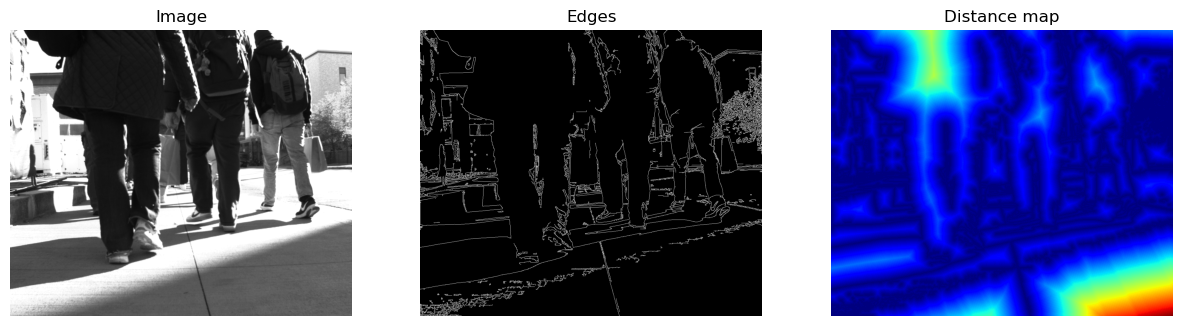

In [4]:
# Paths
base_dir = "/home/aryaman/Forsyth_Data/forsyth_cam0"
img_dir = os.path.join(base_dir, "images")
csv_path = os.path.join(base_dir, "cam0_index.csv")

# Load index CSV
index = pd.read_csv(csv_path)
print("Rows in index:", len(index))
print(index.head())

# Pick one frame (first row)
row = index.iloc[0]
img_path = os.path.join(img_dir, row["filename"])
frame_id = int(row.get("frame_idx", 0))  # use frame_idx if present, else 0

print("Using image:", img_path)
print("frame_id:", frame_id)

# Run through CameraPipeline
pipeline = CameraPipeline()

gray = pipeline.load_image(frame_id, img_path)
edges = pipeline.compute_edges(frame_id)
dist = pipeline.compute_distance_transform(frame_id)

print("gray:", gray.shape, gray.dtype)
print("edges:", edges.shape, np.unique(edges))
print("dist:", dist.shape, dist.min(), dist.max())

# Visualize inline
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(gray, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("Edges")
plt.imshow(edges, cmap="gray")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Distance map")
plt.imshow(dist, cmap="jet")
plt.axis("off")

plt.show()


In [6]:
base_dir = "/home/aryaman/Forsyth_Data/forsyth_cam0"
img_dir = os.path.join(base_dir, "images")
csv_path = os.path.join(base_dir, "cam0_index.csv")

index = pd.read_csv(csv_path)

pipeline = CameraPipeline()

N = len(index)
for i, row in index.iloc[:N].iterrows():
    frame_id = int(row["frame_idx"])
    # CSV column is "file_name", not "filename"
    img_path = os.path.join(img_dir, row["filename"])

    gray = pipeline.load_image(frame_id, img_path)
    pipeline.compute_edges(frame_id)
    pipeline.compute_distance_transform(frame_id)

    if i % 10 == 0:
        print(f"Processed frame {i} (frame_id={frame_id})")

print(f"Precomputed {N} frames.")


Processed frame 0 (frame_id=0)
Processed frame 10 (frame_id=10)
Processed frame 20 (frame_id=20)
Processed frame 30 (frame_id=30)
Processed frame 40 (frame_id=40)
Processed frame 50 (frame_id=50)
Processed frame 60 (frame_id=60)
Processed frame 70 (frame_id=70)
Processed frame 80 (frame_id=80)
Processed frame 90 (frame_id=90)
Precomputed 100 frames.


In [7]:
# index already loaded earlier
# pipeline already filled with all frames via the loop

# 1. Extract frame_ids
frame_ids = index["frame_idx"].to_numpy(dtype=int)

# 2. Extract timestamps (use 'timestamp_sec', not 'stamp_sec')
cam_times = index["timestamp_sec"].to_numpy(dtype=float)

print("Loaded frame_ids:", frame_ids.shape)
print("Loaded cam_times:", cam_times.shape)
print("Camera time range:", cam_times.min(), "→", cam_times.max())

# 3. Build K using your YAML intrinsics
fx = 1501.9374712879626
fy = 1498.8879775647906
cx = 566.5690420612353
cy = 537.1294320963829

K = np.array([
    [fx, 0.0, cx],
    [0.0, fy, cy],
    [0.0, 0.0, 1.0]
], dtype=float)

print("K =\n", K)

# 4. Save everything
out_dir = "/home/aryaman/Forsyth_Data/calib_cache"
os.makedirs(out_dir, exist_ok=True)

joblib.dump(pipeline, os.path.join(out_dir, "camera_pipeline.pkl"))
np.save(os.path.join(out_dir, "cam_times.npy"), cam_times)
np.save(os.path.join(out_dir, "frame_ids.npy"), frame_ids)
np.save(os.path.join(out_dir, "K_cam0.npy"), K)

print("\nSaved to", out_dir)
print(" - camera_pipeline.pkl")
print(" - cam_times.npy")
print(" - frame_ids.npy")
print(" - K_cam0.npy")


Loaded frame_ids: (100,)
Loaded cam_times: (100,)
Camera time range: 1763575010.0591776 → 1763575014.9994082
K =
 [[1.50193747e+03 0.00000000e+00 5.66569042e+02]
 [0.00000000e+00 1.49888798e+03 5.37129432e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Saved to /home/aryaman/Forsyth_Data/calib_cache
 - camera_pipeline.pkl
 - cam_times.npy
 - frame_ids.npy
 - K_cam0.npy
